# Unsupervised learning

In [190]:
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import pandas as pd

# seting master("local[*]") enables multicore processing on all available logical cores on your machine
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [191]:
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# PCA example with diabetes dataset

In [192]:
# we will use pandas to display the data nicely
datasource = pd.read_csv('http://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', delimiter='\t')
datasource.columns = ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu', 'disease_progression']
diabetes_df = spark.createDataFrame(datasource)

In [193]:
print("datasource:", datasource.shape)
diabetes_df

datasource: (442, 11)


DataFrame[age: bigint, sex: bigint, bmi: double, map: double, tc: bigint, ldl: double, hdl: double, tch: double, ltg: double, glu: bigint, disease_progression: bigint]

## Build a pipeline

In [194]:
pipeline_diabetes = Pipeline(stages=[
    # vector assembler concatenates the specified input cols into vectors in the specified output col 
    feature.VectorAssembler(inputCols=['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'],
                           outputCol='features'),
    feature.StandardScaler(withMean=True,
                           inputCol='features', outputCol='zfeatures'),
    # build a principal component object with the same number of components as features (10)
    feature.PCA(k=10, inputCol='zfeatures', outputCol='scores')
]).fit(diabetes_df)

The `loadings` array are the loadings in ISLR equation 10.1.  The loadings are the coefficients in equation 10.1 that are used to perform the linear combination of column vectors in the dataset.  The linear combination of column vectors forms a principal component where each principal component captures a degree of variance in the data.  The first principal component captures the highest degree of variance, the 2nd principal component captures the next highest degree of variance in an orthoganal direction, etc.  <br> <br>
Each loading vector represents a specific direction in the data set's p dimensional space (where p is the number of features) which captures variance.  The direction of the loading vector associated with the first principal component represents the direction which captures the most variance in the data.  The loading vector associated with the 2nd principal component is orthogonal to the 1st component and captures the 2nd most varinace, etc.

In [195]:
loadings = pipeline_diabetes.stages[-1].pc.toArray()

In [196]:
print("loadings.shape", loadings.shape)

# print the first column of the loading array - the first principal component
print(loadings[:,0])

loadings.shape (10, 10)
[-0.2164309  -0.18696688 -0.30316216 -0.27173773 -0.34325511 -0.35186068
  0.28243681 -0.4288337  -0.37861802 -0.32218296]


The proportion of explained variance associated with each of the principal components is found in the explainedVariance attribute of the PCA object.  The explained variance shows the percentage of variance captured by each of the principal components.  For example, the first component captures 40.24 percent of the total variance in the diabetes dataset.  The 2nd component captures 14.92 percent of the total variance.

In [197]:
pipeline_diabetes.stages[-1].explainedVariance

DenseVector([0.4024, 0.1492, 0.1206, 0.0955, 0.0662, 0.0603, 0.0537, 0.0434, 0.0078, 0.0009])

Note that if we sum the explained variance vector that it sums to 1 (or 100%, or very very close to 100%).

In [198]:
sum(pipeline_diabetes.stages[-1].explainedVariance)

0.9999999999999998

The cell below generates a "scree polot" using the explainedVariance attribute.  See ISLR figure 10.4.

Text(0, 0.5, 'Proportion Variance Explained')

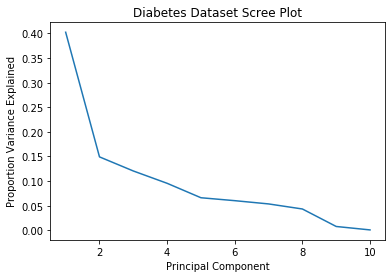

In [199]:
plt.figure()
explained_var = pipeline_diabetes.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var)+1), explained_var)
plt.title("Diabetes Dataset Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Proportion Variance Explained")

Here is another way of looking at the explained variance - plot the cumulative variance vs. the principal components.  See ISLR figure 10.4.

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

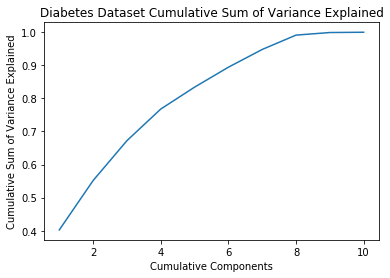

In [200]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title("Diabetes Dataset Cumulative Sum of Variance Explained")
plt.xlabel("Cumulative Components")
plt.ylabel("Cumulative Sum of Variance Explained")

Execute the diabetes pipeline and show the first row of standardized features and PCA scores.  The "scores" are like ISLR equation 10.2.  The scores are produced by projecting the data observations onto the loading vectors.  A projection is performed by multiplying the loading vector by the data observations which "projects" the observation in the direction of the loading vector.

In [201]:
first_row_scores = pipeline_diabetes.transform(diabetes_df).select('zfeatures', 'scores').take(1)
print(first_row_scores)
display(pipeline_diabetes.transform(diabetes_df).toPandas().head())

[Row(zfeatures=DenseVector([0.7996, 1.0643, 1.2956, 0.4593, -0.9287, -0.7312, -0.9114, -0.0544, 0.4181, -0.3706]), scores=DenseVector([-0.5865, -1.9446, 0.5885, 0.0827, 0.2564, -1.0101, -0.1796, 0.7566, 0.1809, 0.0489]))]


,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression,features,zfeatures,scores
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151,"[59.0, 2.0, 32.1, 101.0, 157.0, 93.2, 38.0, 4.0, 4.8598, 87.0]","[0.7995940351018838, 1.0642824935361896, 1.2956203368923545, 0.4593200957947719, -0.9286934669133657, -0.7312360195916786, -0.911417758692523, -0.054437501961848156, 0.41805720957971554, -0.37056862835587934]","[-0.5865345004628008, -1.9446286568771163, 0.5885385822773391, 0.08272184000589833, 0.25638973015942057, -1.01006556830413, -0.17964046398342473, 0.7565734789753054, 0.1808704127968728, 0.04889745662250157]"
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75,"[48.0, 1.0, 21.6, 87.0, 183.0, 103.2, 70.0, 3.0, 3.8918, 69.0]","[-0.039522347083602145, -0.937474366646771, -1.0809552860148093, -0.5528780911049113, -0.17742320633555317, -0.4024301347126671, 1.5626428456539025, -0.8293610403559584, -1.4349624889734371, -1.9362850421633024]","[2.8284203725740173, 1.3705287266001895, 0.02789825293130943, 0.4694764273892683, 0.14310718139790288, -1.0118688438815724, 0.22414356855169726, -0.1882230580999913, -0.5045562308482942, -0.043549267281752554]"
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141,"[72.0, 2.0, 30.5, 93.0, 156.0, 93.6, 41.0, 4.0, 4.6728, 85.0]","[1.7912770322301852, 1.0642824935361896, 0.9334754800684053, -0.11907886814790421, -0.9575884769355892, -0.7180837841965184, -0.6794745770350455, -0.054437501961848156, 0.0600874950864923, -0.5445371187789263]","[-0.2718205368550441, -1.6330507612915226, 0.7384070197965493, 0.7905964088659286, 1.1625529919061006, -1.1115030518064313, -0.46192812623204194, 0.8422485897646419, 0.02532452629581726, 0.05411385348062586]"
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206,"[24.0, 1.0, 25.3, 84.0, 198.0, 131.4, 40.0, 5.0, 4.8903, 89.0]","[-1.8703217263973897, -0.937474366646771, -0.24349530460942795, -0.7697777025834148, 0.2560019439978002, 0.5248024606461454, -0.7567889709208713, 0.7204860364322621, 0.47644264429652455, -0.19660013793283232]","[-0.04922536519991402, 0.3818453424540574, -2.010753160163291, -1.3716621074280093, -0.2552807400982159, 0.4447844932561747, 0.48155598133078814, -0.3674545221749749, 0.13770135970813036, 0.0744738779679798]"
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135,"[50.0, 1.0, 23.0, 101.0, 192.0, 125.4, 52.0, 4.0, 4.2905, 80.0]","[0.11304426785921348, -0.937474366646771, -0.7640785362938545, 0.4593200957947719, 0.08263188386445885, 0.3275189297187386, 0.17098375570903823, -0.054437501961848156, -0.6717404292491173, -0.9794583448365439]","[0.7555651902794538, 0.8110412184450315, -0.05717338868807276, 0.13733946654946544, 0.13325084110560537, -0.8136373169839043, 0.4360414706461321, -1.0585513315417305, -0.04423374447793292, 0.010901919044017239]"


Assign the first row of standardized features to the variable `z`.

In [202]:
z = pipeline_diabetes.transform(diabetes_df).select('zfeatures', 'scores').first()['zfeatures']
print(z)

[0.7995940351018838,1.0642824935361896,1.2956203368923545,0.4593200957947719,-0.9286934669133657,-0.7312360195916786,-0.911417758692523,-0.054437501961848156,0.41805720957971554,-0.37056862835587934]


The purpose of the next cell is to show that if we multiply the first loading vector by the first observation row we will obtain the same score which we extracted from the pipeline above.  The matrix dot product of a standardized observation with the loadings vector projects the observation onto the loading vector (see equation 10.2 in ISLR).  Also note that the resulting score is equal to the score for the first row computed by the pipeline above.

In [203]:
scores = z.dot(loadings[:,0])
print(scores)

-0.5865345004628009


In the next cell, we multiply the first observation row of the data by all of the loading vectors producing a score for each of the 10 principal components.  Note that the resulting array of scores is equal to the scores for the first row computed by the pipeline above.

In [204]:
scores = z.dot(loadings)
print(scores)

[-0.5865345  -1.94462866  0.58853858  0.08272184  0.25638973 -1.01006557
 -0.17964046  0.75657348  0.18087041  0.04889746]


The purpose of the following cell is the show that we can do an inverse transform which transforms the scores from the projection space back to the original data.  The The dot product of the loading vectors with the scores produces an approximation of the original observation row held in variable `z` (see equation 10.5 in ISLR).  The more loadings we use for the inverse transform, the closer the approximation to the original observation row.  The cell below computes the original data using from between 4 and 10 loading vectors.  Notice how the resulting transformed data gets closer to the original data held in 'z' above as the number of loading vectors increases.

In [205]:
print("all loadings shape:", loadings.shape)
print("all scores shape:", scores.shape)
print()

num_loadings = loadings.shape[1]
for i in np.arange(4, num_loadings+1):
    print("num_loadings:", i)
    print("loadings shape:", loadings[:,:i].shape)
    print("scores shape:", scores[:i].shape)
    inverse_xform = loadings[:,:i].dot(scores[:i])
    print("inverse xform shape:", inverse_xform.shape)
    print("inverse_xform:", inverse_xform)
    print()

all loadings shape: (10, 10)
all scores shape: (10,)

num_loadings: 4
loadings shape: (10, 4)
scores shape: (4,)
inverse xform shape: (10,)
inverse_xform: [ 0.36604541  0.85469882  0.53897377  0.73214235 -0.94769719 -0.82510297
 -0.91662271  0.15941187  0.28857141  0.50989389]

num_loadings: 5
loadings shape: (10, 5)
scores shape: (5,)
inverse xform shape: (10,)
inverse_xform: [ 0.54215325  0.75894648  0.5058142   0.60731275 -0.98081759 -0.85502933
 -0.97943845  0.19624122  0.32745007  0.50183738]

num_loadings: 6
loadings shape: (10, 6)
scores shape: (6,)
inverse xform shape: (10,)
inverse_xform: [ 0.77024155  0.71682127  0.91302331  0.88284174 -0.98627012 -0.72042643
 -1.08686299  0.23051869  0.14692016 -0.31133202]

num_loadings: 7
loadings shape: (10, 7)
scores shape: (7,)
inverse xform shape: (10,)
inverse_xform: [ 0.78991759  0.72896895  1.00641379  0.82523917 -0.99949948 -0.6790131
 -1.08550707  0.21772038  0.03063855 -0.24715244]

num_loadings: 8
loadings shape: (10, 8)
scores 

The cell below prints the first row scores from the original transormation we did above.  Note that the zfeatures in the cell below match very closely with the inverse_xform in the cell above using 10 loadings.  Also note that as the number of loading vectors used in the inverse xform in the call above reduces from 10, the inverse xform becomes less and less accurate.

In [206]:
print("first_row_scores from above:\n", first_row_scores)

first_row_scores from above:
 [Row(zfeatures=DenseVector([0.7996, 1.0643, 1.2956, 0.4593, -0.9287, -0.7312, -0.9114, -0.0544, 0.4181, -0.3706]), scores=DenseVector([-0.5865, -1.9446, 0.5885, 0.0827, 0.2564, -1.0101, -0.1796, 0.7566, 0.1809, 0.0489]))]


Note that the sum of the squares of the loading columns equal 1 as per ISLR equation 10.3.

In [207]:
np.sum(np.square(loadings), axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Examine the principal components

In [208]:
list(zip(['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu'], 
         loadings[:, 0], loadings[:, 1]))

[('age', -0.2164308964889745, 0.04436721239323424),
 ('sex', -0.18696687908602558, -0.38654720385516306),
 ('bmi', -0.30316216313887745, -0.15628128429437424),
 ('map', -0.2717377304844056, -0.13826600177995452),
 ('tc', -0.3432551083789176, 0.573026908841581),
 ('ldl', -0.3518606824177599, 0.45594185472401333),
 ('hdl', 0.28243681319974895, 0.5062390689011846),
 ('tch', -0.42883369801333127, -0.06818071604589006),
 ('ltg', -0.37861801599069916, -0.026186995954152716),
 ('glu', -0.32218295508497025, -0.08494884202867264)]

# Analysis of IM courses

In [209]:
im_courses = spark.createDataFrame(pd.read_csv('https://github.com/daniel-acuna/data_science_programs/raw/master/data/im_masters_ischool.csv'))

In [210]:
im_courses.show()

+-------+----+-------+--------------------+--------------------+
| course|core|credits|               title|         description|
+-------+----+-------+--------------------+--------------------+
|IST 553|  IM|      3|Information Archi...|Building and mana...|
|IST 558| CAS|      3|Technologies in W...|Concepts and tech...|
|IST 565| CAS|      3|         Data Mining|Introduction to d...|
|IST 601|  IM|      3|Information and I...|A broad overview ...|
|IST 614|  IM|      3|Management Princi...|Basic ideas, conc...|
|IST 617|  IM|      3|Motivational Aspe...|Theories of motiv...|
|IST 618|  IM|      3|  Information Policy|Public policy iss...|
|IST 619|  IM|      3|Applied Economics...|Economic principl...|
|IST 621|  IM|      3|Introduction to I...|Overview of gener...|
|IST 631|  IM|      3|Theory of Classif...|Classification is...|
|IST 639|  IM|      3|Enterprise Techno...|Coverage of manag...|
|IST 641|  IM|      3|   User-Based Design|System design bas...|
|IST 645|  IM|      3|Man

## Let's transform course descriptions into vectors

In [211]:
tokenizer = feature.RegexTokenizer(minTokenLength=2)\
  .setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("description")\
  .setOutputCol("words")

import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()

sw_filter = feature.StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = feature.CountVectorizer(inputCol='filtered', outputCol='tf')
idf = feature.IDF(inputCol='tf', outputCol='tfidf')

Let's create a pipeline that transforms descriptions into TFIDF:

In [212]:
tfidf = Pipeline(stages=[tokenizer, sw_filter, cv, idf]).fit(im_courses)

In [213]:
tfidf.transform(im_courses).toPandas().head()

,course,core,credits,title,description,words,filtered,tf,tfidf
0,IST 553,IM,3,Information Architecture for Internet Services,"Building and management of Internet information services, including information organization, information management, and information dissemination. Understanding of the use of Internet technologies within an organizational context. Practice with current technologies.","[building, and, management, of, internet, information, services, including, information, organization, information, management, and, information, dissemination, understanding, of, the, use, of, internet, technologies, within, an, organizational, context, practice, with, current, technologies]","[building, management, internet, information, services, including, information, organization, information, management, information, dissemination, understanding, use, internet, technologies, organizational, context, practice, current, technologies]","(4.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(1.8572224325243911, 1.444269434866395, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2188758248682006, 0.0, 0.0, 1.6094379124341003, 1.7635885922613586, 0.0, 0.0, 1.7635885922613586, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.169053700369523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.169053700369523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.169053700369523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.456735772821304, 0.0, 0.0, 0.0, 0.0, 2.456735772821304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,IST 558,CAS,3,Technologies in Web Content Management,"Concepts and techniques in web content representation, organization, presentation, development, and management with the eXtensible Markup Language (XML), including basic XML syntax, vocabulary specification, data modeling, transformation, and Document Object Model (DOM).","[concepts, and, techniques, in, web, content, representation, organization, presentation, development, and, management, with, the, extensible, markup, language, xml, including, basic, xml, syntax, vocabulary, specification, data, modeling, transformation, and, document, object, model, dom]","[concepts, techniques, web, content, representation, organization, presentation, development, management, extensible, markup, language, xml, including, basic, xml, syntax, vocabulary, specification, data, modeling, transformation, document, object, model, dom]","(0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.7221347174331975, 1.252762968495368, 1.0704414117014134, 1.252762968495368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.7635885922613586, 0.0, 0.0, 0.0, 1.9459101490553132, 0.0, 0.0, 0.0, 1.9459101490553132, 2.169053700369523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.456735772821304, 0.0, 0.0, 0.0, 0.0, 0.0, 2.169053700369523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.

The PCA spark functions do not work with Sparse vectors. We need to create a UDF that performs a sparse to dense transformation  We need to define a *Python* function that takes as input a `tfidf` column and then returns the dense version of it.  If we get the first row of the transformation, we can examine the type of `tfidf`

In [214]:
tfidf_sample = tfidf.transform(im_courses).first().tfidf
tfidf_sample

SparseVector(357, {0: 1.8572, 1: 1.4443, 9: 3.2189, 12: 1.6094, 13: 1.7636, 16: 1.7636, 33: 2.1691, 49: 2.1691, 61: 2.1691, 80: 2.4567, 85: 2.4567, 101: 5.7244, 209: 2.8622, 216: 2.8622, 330: 2.8622})

In [215]:
type(tfidf_sample)

pyspark.ml.linalg.SparseVector

We need to define a function that returns a dense version. For that, we will make use of the Vectors class

In [216]:
from pyspark.ml.linalg import Vectors

In [217]:
Vectors.dense(tfidf_sample)

DenseVector([1.8572, 1.4443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2189, 0.0, 0.0, 1.6094, 1.7636, 0.0, 0.0, 1.7636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.7244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [218]:
type(Vectors.dense(tfidf_sample))

pyspark.ml.linalg.DenseVector

We need to work with `pyspark.ml.linalg.DenseVector` because that's what Spark ML expects (as opposed to a Numpy array or a pyspark sparse vector)

So, let's define the function:

In [219]:
def to_dense(sparse_vector):
    return Vectors.dense(sparse_vector)

In [220]:
to_dense(tfidf_sample)

DenseVector([1.8572, 1.4443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.2189, 0.0, 0.0, 1.6094, 1.7636, 0.0, 0.0, 1.7636, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.1691, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 2.4567, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.7244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

Now, to define a user defined custom function (UDF) for Spark SQL, we need to provide the **return** type of the function to the constructor in `functions.udf`. The return type of `to_dense` is `VectorUDT` defined in `pyspark.ml.linalg.VectorUDT`

In [221]:
from pyspark.ml.linalg import VectorUDT

In [222]:
to_dense_udf = fn.udf(to_dense, VectorUDT())

Now we can use this function as part of our transformations

In [223]:
tfidf.transform(im_courses).select('tfidf', to_dense_udf('tfidf').alias('dense_tfidf')).show(5, 60)

+------------------------------------------------------------+------------------------------------------------------------+
|                                                       tfidf|                                                 dense_tfidf|
+------------------------------------------------------------+------------------------------------------------------------+
|(357,[0,1,9,12,13,16,33,49,61,80,85,101,209,216,330],[1.8...|[1.8572224325243911,1.444269434866395,0.0,0.0,0.0,0.0,0.0...|
|(357,[1,2,3,4,16,20,24,25,43,49,68,90,103,130,160,190,210...|[0.0,0.7221347174331975,1.252762968495368,1.0704414117014...|
|(357,[2,3,8,21,28,29,70,93,97,127,134,177,223,248,252,258...|[0.0,0.0,1.252762968495368,1.0704414117014134,0.0,0.0,0.0...|
|(357,[0,30,37,42,97,127,171,187,215,233,307],[0.928611216...|[0.9286112162621956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...|
|(357,[0,1,3,4,6,13,16,27,34,43,59,73,135,170,174,225,270,...|[0.4643056081310978,0.7221347174331975,0.0,1.070441411701...|
+-------

Moreover, we want to make this as part of a Pipeline. This is somewhat obscure and undocumented Spark functionality. We will now define a simple `Transformer` object that will apply the `to_dense_udf` to an input column as part of a Transformer object.

In [224]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

class Densify(Transformer, HasInputCol, HasOutputCol):
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, stopwords=None):
        super(Densify, self).__init__()
        self._setDefault()
#         print(self._input_kwargs)
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, to_dense_udf(in_col))

The cell below creates a `Densify` transformer object that can be used in a Spark pipeline.

In [225]:
dense_tfidf = Densify(inputCol='tfidf', outputCol='dense_tfidf')

The cell below uses the `dense_tfidf` transformer in a pipeline.

In [259]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf]).fit(im_courses)
pipeline2_model.transform(im_courses).select('tfidf', 'dense_tfidf').show(20, 80)

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                           tfidf|                                                                     dense_tfidf|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|(357,[0,1,9,11,15,16,35,55,61,103,108,116,151,285,324],[1.8572224325243911,1....|[1.8572224325243911,1.444269434866395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.218875824...|
|(357,[1,2,3,5,16,23,25,30,46,55,63,67,82,119,145,160,190,194,195,230,287,289,...|[0.0,0.7221347174331975,1.252762968495368,1.0704414117014134,0.0,1.2527629684...|
|(357,[2,3,8,22,27,28,62,65,84,122,130,150,169,177,180,187,234,250,268,316,322...|[0.0,0.0,1.252762968495368,1.0704414117014134,0.0,0.0,0.0,0.0,1.4759065198095...|
|(357,[0,19,37,4

The cell below defines a standard scaler object which will be used to standardize data before applying unsupervised learning algorithms.

In [227]:
# standardize features - it doesn't work in Spark 2.1
center = feature.StandardScaler(withMean=True, withStd=False, inputCol='dense_tfidf', outputCol='centered_tfidf')

In the cell below we define a PCA transformer.  PCA needs the number of principal components to be learned `k`:

In [228]:
pca = feature.PCA(k=10, inputCol='centered_tfidf', outputCol='pca_feat')

For KMeans, we need to provide the number of clusters, but we will normalize the vectors so that they have unit length.  The cell below defines a `Normalizer` transformer which will normalize vectors to unit length.

In [229]:
norm = feature.Normalizer(inputCol="centered_tfidf", outputCol="norm_tfidf", p=2.0)

The cell below defines a Spark KMeans clustering object.

In [230]:
kmeans = clustering.KMeans(k=5, featuresCol='norm_tfidf', predictionCol='kmeans_feat')

In [231]:
pipeline = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf, center, norm, kmeans, pca])

In [232]:
pipeline_model = pipeline.fit(im_courses)

In [233]:
if is_databricks():
  pipeline_model.transform(im_courses).show(5, 10)
else:
  pipeline_model.transform(im_courses).toPandas().head()

In [234]:
# note: pca_feat col is the PCA loadings
pipeline_model.transform(im_courses).select('course', 'pca_feat', 'kmeans_feat').show(5, 60)

+-------+------------------------------------------------------------+-----------+
| course|                                                    pca_feat|kmeans_feat|
+-------+------------------------------------------------------------+-----------+
|IST 553|[-0.6752213340342716,0.5785435268413691,-0.07339130587452...|          3|
|IST 558|[-1.0560092197231885,0.16173650604119563,1.76742656265282...|          3|
|IST 565|[0.19618219422529945,0.3954758666709369,0.745455205235986...|          4|
|IST 601|[-0.6823791849888864,0.0777981633234236,0.242940814663267...|          4|
|IST 614|[-1.3508184757797232,0.2786365081125673,0.042220706401105...|          2|
+-------+------------------------------------------------------------+-----------+
only showing top 5 rows



# Interpreation

We can examine the PCA loadings:

In [235]:
import pandas as pd

In [236]:
pipeline_model.stages

[RegexTokenizer_4c03e5d89fc4,
 StopWordsRemover_b9560a5cda7f,
 CountVectorizer_c6fdfa323aee,
 IDF_80bd10a65d1f,
 Densify_96a1bfa9e2ef,
 StandardScaler_8202678db3ba,
 Normalizer_671d5cc775a1,
 KMeans_8e4263ca2803,
 PCA_329377757165]

In [237]:
pca_model = pipeline_model.stages[-1]

In [238]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()
pc3 = pca_model.pc.toArray()[:, 2].tolist()

In [239]:
vocabulary = pipeline_model.stages[2].vocabulary

In [240]:
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2, pc3]).T.rename(columns={0: 'word', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2',
                                                                          3: 'load_pc3',})
print(pc_loadings.shape)

(357, 4)


Show the smallest and largest loadings

In [241]:
# smallest and biggest loadings of pc1
pd.concat((pc_loadings.sort_values('load_pc1').head(), 
           pc_loadings.sort_values('load_pc1').tail()))

,word,load_pc1,load_pc2,load_pc3
38,required,-0.067063,0.0054385,0.0715218
32,processing,-0.0654304,0.00737648,0.0743025
74,computational,-0.0613542,0.00504601,0.0764562
70,linguistic,-0.0613542,0.00504601,0.0764562
7,students,-0.0579638,0.00405441,0.0680286
72,architecture,0.188491,-0.051103,0.00445523
97,complex,0.188491,-0.051103,0.00445523
37,enterprise,0.254813,-0.453853,-0.0290984
26,databases,0.275076,0.199085,0.0735311
21,database,0.538651,0.366988,0.0595601


In [242]:
# smallest and biggest loadings of pc2
pd.concat((pc_loadings.sort_values('load_pc2').head(), 
           pc_loadings.sort_values('load_pc2').tail()))

,word,load_pc1,load_pc2,load_pc3
37,enterprise,0.254813,-0.453853,-0.0290984
110,computing,0.169875,-0.302568,-0.019399
56,large,0.144783,-0.263025,-0.0181318
5,systems,0.0903704,-0.160692,0.0276732
260,comprise,0.0849375,-0.151284,-0.00969948
241,implementing,0.134663,0.091747,0.01489
120,security,0.116207,0.094556,-0.129068
105,warehouses,0.116554,0.097372,0.0149755
26,databases,0.275076,0.199085,0.0735311
21,database,0.538651,0.366988,0.0595601


In [243]:
# smallest and biggest loadings of pc3
pd.concat((pc_loadings.sort_values('load_pc3').head(), 
           pc_loadings.sort_values('load_pc3').tail()))

,word,load_pc1,load_pc2,load_pc3
71,public,0.00144676,0.0368293,-0.330519
92,policy,0.00144676,0.0368293,-0.330519
57,economic,-0.0149275,0.0125956,-0.184823
137,legal,0.000723382,0.0184146,-0.165259
252,expression,0.000723382,0.0184146,-0.165259
94,administration,0.0155463,0.00854415,0.079552
24,modeling,0.00457799,0.00875369,0.0798089
49,projects,-0.0324584,-0.0187311,0.0871006
2,data,0.0864014,0.0851734,0.133236
33,metadata,-0.0223883,-0.0428104,0.194214


# Visualize fit with 2 dimensional PCA

The cell below creates a new pipeline to compute PCA scores on the course descriptions.

In [244]:
pipeline2_model = Pipeline(stages=[tokenizer, sw_filter, cv, idf, dense_tfidf, 
                                   feature.Normalizer(inputCol='dense_tfidf', outputCol='norm_tfidf'), 
                                   feature.StandardScaler(withMean=True, withStd=False, 
                                                          inputCol='norm_tfidf',
                                                          outputCol='centered_tfidf'),
                                   feature.PCA(k=2, inputCol='centered_tfidf', outputCol='pca_feat2')])\
    .fit(im_courses)

The cell below extracts the PCA scores from the transformed pipeline2_model.

In [245]:
course_names = np.array(im_courses.select('course').rdd.map(lambda x: x['course']).collect())
X = np.array(pipeline2_model.transform(im_courses).select('pca_feat2').rdd.map(lambda x: x['pca_feat2']).collect())
print("X.shape:", X.shape)

X.shape: (34, 2)


Filter out scores that are lower than .2 to limit the amount of data we are plotting so the plot isn't too "busy"

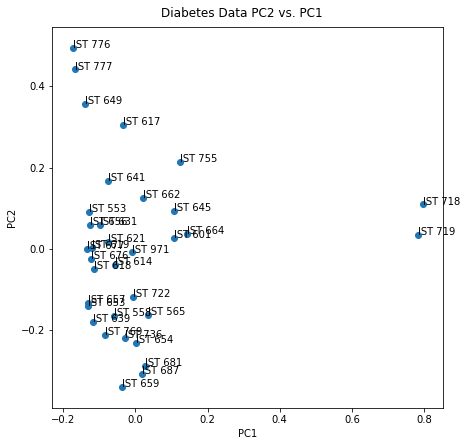

None

In [254]:
# now plot the data
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(X[:,0], X[:,1])
fig.suptitle("Diabetes Data PC2 vs. PC1", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

for i, txt in enumerate(course_names):
    ax.annotate(txt, (X[i,0], X[i,1]))
    
display(plt.show())

The cell below sets up to print a zoomed in plot by filtering by data less than 0.2

In [255]:
idx = np.abs(X[:, 0]) < 0.2
X = X[idx]
course_names = course_names[idx]

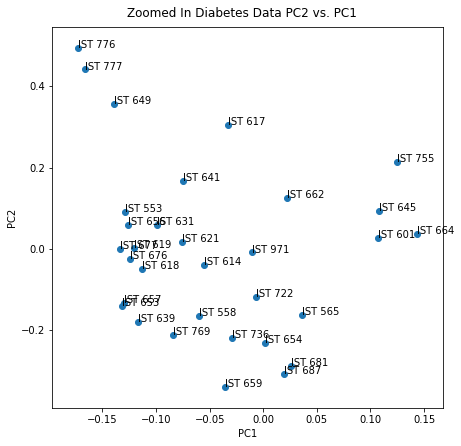

None

In [256]:
# now plot the zoomed data
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(X[:,0], X[:,1])
fig.suptitle("Zoomed In Diabetes Data PC2 vs. PC1", y=.92)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

for i, txt in enumerate(course_names):
    ax.annotate(txt, (X[i,0], X[i,1]))
    
display(plt.show())

In [154]:
pca_model = pipeline2_model.stages[-1]

In [155]:
pc1 = pca_model.pc.toArray()[:, 0].tolist()
pc2 = pca_model.pc.toArray()[:, 1].tolist()

In [156]:
vocabulary = pipeline2_model.stages[2].vocabulary

In [157]:
pc_loadings = pd.DataFrame([vocabulary, pc1, pc2]).T.rename(columns={0: 'word', 
                                                                     1: 'load_pc1',
                                                                     2: 'load_pc2'})

In [158]:
pc_loadings.sort_values('load_pc1').\
    apply({'word': lambda x: x, 'load_pc1': np.abs}, axis=0).head(5)

,word,load_pc1
14,research,0.11137
17,digital,0.0683895
7,design,0.0668912
10,issues,0.0572029
41,networks,0.0537774


In [159]:
pc_loadings.sort_values('load_pc2').\
    apply({'word': lambda x: x, 'load_pc2': np.abs}, axis=0).head(5)

,word,load_pc2
2,data,0.243194
5,systems,0.1452
24,databases,0.139927
11,analysis,0.133891
56,metadata,0.128186


# Examine K-means

The cell below displays the im_courses dataframe, followed by a print out of the course

In [160]:
pd.set_option('display.max_colwidth', -1)
if is_databricks(): 
  print("original im_courses:")
  im_courses.show(5, 80)
  print("courses grouped by k-means group:")
  pipeline_model.transform(im_courses).\
           groupBy('kmeans_feat').agg(fn.collect_list(
           fn.concat_ws('-', fn.col('course'), fn.col('title'))).alias('courses')).show(5, 80)
else:
  display("im_courses head:", im_courses.toPandas().head())
  display("courses grouped by k-means group:", pipeline_model.transform(im_courses).\
          groupBy('kmeans_feat').agg(fn.collect_list(
          fn.concat_ws('-', fn.col('course'), fn.col('title'))).alias('courses')).toPandas().head())

'im_courses head:'

,course,core,credits,title,description
0,IST 553,IM,3,Information Architecture for Internet Services,"Building and management of Internet information services, including information organization, information management, and information dissemination. Understanding of the use of Internet technologies within an organizational context. Practice with current technologies."
1,IST 558,CAS,3,Technologies in Web Content Management,"Concepts and techniques in web content representation, organization, presentation, development, and management with the eXtensible Markup Language (XML), including basic XML syntax, vocabulary specification, data modeling, transformation, and Document Object Model (DOM)."
2,IST 565,CAS,3,Data Mining,"Introduction to data mining techniques, familiarity with particular real-world applications, challenges involved in these applications, and future directions of the field. Optional hands-on experience with commercially available software packages."
3,IST 601,IM,3,Information and Information Environments,"A broad overview of the field and an orientation to the School of Information Studies. Describes the past, present, and future of information studies."
4,IST 614,IM,3,Management Principles for Information Professionals,"Basic ideas, concepts and perspectives of management as they apply to the information professions. Students learn to understand and apply basic principles of organization theory and behavior and managerial techniques needed to improve organizational effectiveness."


'courses grouped by k-means group:'

,kmeans_feat,courses
0,1,"[IST 645-Managing Information Systems Projects, IST 656-Telecommunications and Enterprise Network Management II, IST 664-Natural Language Processing, IST 676-Foundations of Digital Data]"
1,3,"[IST 553-Information Architecture for Internet Services, IST 558-Technologies in Web Content Management, IST 618-Information Policy, IST 641-User-Based Design, IST 653-Telecommunications and Enterprise Network Management I, IST 654-Information Systems Analysis, IST 677-Creating, Managing, and Preserving Digital Assets, IST 681-Metadata, IST 687-Applied Data Science, IST 722-Data Warehouse]"
2,4,"[IST 565-Data Mining, IST 601-Information and Information Environments, IST 617-Motivational Aspects of Information Use, IST 621-Introduction to Information Management, IST 639-Enterprise Technologies, IST 659-Data Administration Concepts and Database Management, IST 662-Instructional Strategies and Techniques for Information Professionals, IST 718-Advanced Information Analytics, IST 719-Information Visualization, IST 755-Strategic Management of Information Resources, IST 769-Advanced Database Administration Concepts and Database Management, IST 971-Internship in Information Studies]"
3,2,"[IST 614-Management Principles for Information Professionals, IST 619-Applied Economics for Information Managers, IST 657-Basics of Information Retrieval Systems]"
4,0,"[IST 631-Theory of Classification and Subject Representation, IST 649-Human Interaction with Computers, IST 736-Text Mining, IST 776-Research Methods in Information Science and Technology, IST 777-Statistical Methods in Information Science and Technology]"


# Make recommendations

To make recommendations, we need compute the distance between a vector and all the other courses in our dataset. To do this, we need to define a User Defined Function (UDF) that takes as input two column vectors and returns the distance between them.

In [161]:
from pyspark.sql import types

In [162]:
import numpy as np
def l2_dist(c1, c2):    
    return float(np.sqrt((c1 - c2).T.dot((c1 - c2))))

Let's take the PCA features of IST 718.

In [163]:
l2_dist_udf = fn.udf(l2_dist, types.FloatType())

Spark doesn't allow a cross join without a condition because it could be too computationally expensive. The command in the cell below triggers a cross join using the regular inner join syntax.  A cross join is used when you wish to create combination of every row from two tables. All row combinations are included in the result; this is commonly called cross product join. A common use for a cross join is to create obtain all combinations of items, such as colors and sizes.

In [164]:
spark.sql("SET spark.sql.crossJoin.enabled=TRUE").show()

+--------------------+-----+
|                 key|value|
+--------------------+-----+
|spark.sql.crossJo...| TRUE|
+--------------------+-----+



In [165]:
if is_databricks():
  pipeline_model.transform(im_courses).\
        where('course == "IST 718"').\
        select(fn.col("pca_feat").alias('ist718_feat')).\
        join(pipeline_model.transform(im_courses)).\
        withColumn('dist', l2_dist_udf('pca_feat', 'ist718_feat')).\
        select("course", "description", "dist").\
        orderBy(fn.asc("dist")).\
        show(5, 80)  
else:
  display(pipeline_model.transform(im_courses).\
          where('course == "IST 718"').\
          select(fn.col("pca_feat").alias('ist718_feat')).\
          join(pipeline_model.transform(im_courses)).\
          withColumn('dist', l2_dist_udf('pca_feat', 'ist718_feat')).\
          select("course", "description", "dist").\
          orderBy(fn.asc("dist")).\
          limit(10).\
          toPandas())

,course,description,dist
0,IST 718,"A broad introduction to analytical processing tools and techniques for information professionals. Students will develop a portfolio of resources, demonstrations, recipes, and examples of various analytical techniques.",0.000000
1,IST 719,"A broad introduction to data visualization for information professionals. Students will develop a portfolio of resources, demonstrations, recipes, and examples of various data visualization techniques.",1.466475
2,IST 565,"Introduction to data mining techniques, familiarity with particular real-world applications, challenges involved in these applications, and future directions of the field. Optional hands-on experience with commercially available software packages.",4.206517
3,IST 662,"Introduction to information literacy models for application to instruction in information organizations. Focus on strategies and techniques for designing, presenting, and evaluating information technology training and training materials for real clients.",4.281012
4,IST 601,"A broad overview of the field and an orientation to the School of Information Studies. Describes the past, present, and future of information studies.",4.523474
5,IST 971,Fully supervised internship experience. Prereq: IST masters students only. Must meet GPA requirements and complete a learning agreement with site supervisor.,4.798213
6,IST 736,"Introduces concepts and methods for knowledge discovery from large amount of text data, and the application of text mining techniques for business intelligence, digital humanities, and social behavior analysis.",5.518248
7,IST 755,"Seminar. Integration of previous learning on the various components of management, user needs, and technologies. In-depth review and use of case studies on a range of critical information resources management areas.",5.552835
8,IST 621,"Overview of general management concepts, IM implementation concerns and strategies, information life cycle management, and preparation for an IM career.",5.588045
9,IST 656,"Hardware and software technologies in telecommunication and information networks. TCP/IP protocols. Design, maintenance and management.",5.759579


To Do:  Create a biplot as part of this notebook

In [166]:
def biplot(score, coeff, score_labels=None, col_labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    plt.scatter(xs * scalex, ys * scaley, c = score_labels)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if col_labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, col_labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()